In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import minmax_scale,StandardScaler
from tqdm import tqdm_notebook

In [3]:
os.chdir(r"C:\Users\Roozbeh\Vehicular Data\London")

In [4]:
df = pd.read_csv('AA_LONDON_DATA_VER3_DATA_TABLE.csv')

In [5]:
camdf = pd.read_csv('AA_LONDON_CAMERA_DATA_TABLE.csv')

In [58]:
camdf[camdf.CAMERA_ID == 144]

,CAMERA_ID,CAMERA_NAME,CAMERA_DESC,EASTING,NORTHING,GEO_LAT,GEO_LON,CONGESTION_ZONE
39,144,547600,Kingsway/High Holborn,530514.0,181528.0,0.0,0.0,0


In [59]:
camdf.drop(labels=39,inplace=True)

In [6]:
os.chdir(r"./spatio_temporal_London/")

In [63]:
mergedf = df.merge(camdf,left_on="CAMERA_ID",right_on="CAMERA_ID")

tdf = mergedf[["CAMERA_ID","GEO_LON","GEO_LAT","DL_TIMESTAMP_CITY","DENSITY_VALUE"]].copy()

tdf['TIMESTAMP']  = pd.to_datetime(tdf['DL_TIMESTAMP_CITY'],format="%d-%b-%y %I.%M.%S.000000000 %p")

try:
    tdf.drop("DL_TIMESTAMP_CITY",axis=1,inplace=True)
except:
    print("column doesn't exist")

In [64]:
tdf["TIME_EPOCH"] = (tdf.TIMESTAMP.astype(np.int64) // 10**9)

In [65]:
tdf["TIME_EPOCH"] -= tdf.TIME_EPOCH.min()

In [66]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP,TIME_EPOCH
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34,3642693
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04,3643143


In [67]:
yscaler = StandardScaler()

In [68]:
yscaler.fit(tdf["DENSITY_VALUE"].values.reshape((-1,1)))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [69]:
tdf.loc[:,"SCALED_DENSITY_VALUE"] = yscaler.transform(tdf["DENSITY_VALUE"].values.reshape((-1,1)))

In [70]:
tdf[:2]

,CAMERA_ID,GEO_LON,GEO_LAT,DENSITY_VALUE,TIMESTAMP,TIME_EPOCH,SCALED_DENSITY_VALUE
0,182,-0.245122,51.616876,16109.680,2010-11-22 13:46:34,3642693,-0.461586
1,182,-0.245122,51.616876,11318.897,2010-11-22 13:54:04,3643143,-0.908874


In [71]:
Xfeatures = ["GEO_LON","GEO_LAT"]
Tfeature = "TIME_EPOCH"
target = "SCALED_DENSITY_VALUE"

In [72]:
from pandas.plotting import autocorrelation_plot

In [73]:
tdf_30min = tdf.groupby(["CAMERA_ID",pd.Grouper(key="TIMESTAMP",freq='30min')]).mean()

In [74]:
tdf_30min.TIME_EPOCH = tdf_30min.TIME_EPOCH.astype(np.int64)

In [75]:
tdf_30min[:5]

GEO_LON    GEO_LAT  DENSITY_VALUE  TIME_EPOCH  \
CAMERA_ID TIMESTAMP                                                             
1         2010-10-11 09:30:00 -0.218065  51.481782   51667.918000          90   
          2010-10-11 10:00:00 -0.218065  51.481782   44098.589500        1395   
          2010-10-11 10:30:00 -0.218065  51.481782   50642.797333        3030   
          2010-10-11 11:00:00 -0.218065  51.481782   48398.930000        4410   
          2010-10-11 11:30:00 -0.218065  51.481782   49286.311800        6660   

                               SCALED_DENSITY_VALUE  
CAMERA_ID TIMESTAMP                                  
1         2010-10-11 09:30:00              2.858280  
          2010-10-11 10:00:00              2.151575  
          2010-10-11 10:30:00              2.762570  
          2010-10-11 11:00:00              2.553073  
          2010-10-11 11:30:00              2.635923

In [76]:
def plot_timeseries(data, cam_id_to_vis):
    
    plt.figure(figsize=(20,12))
    for i,_id in enumerate(cam_id_to_vis):
        group = data.groupby("CAMERA_ID").get_group(_id)
        group = group.reset_index(level=0)
        ts = group.SCALED_DENSITY_VALUE
        plt.subplot(len(cam_id_to_vis),1,i+1)
        plt.plot(ts)     
    
    
    plt.show()    


In [77]:
camdf[:2]

,CAMERA_ID,CAMERA_NAME,CAMERA_DESC,EASTING,NORTHING,GEO_LAT,GEO_LON,CONGESTION_ZONE
0,105,546600,A4 Cromwell Road by Earls Court Road,525351.39,178843.06,51.494572,-0.195707,0
1,106,546610,A4 Great West Road By Macbeth Street,522781.00,178369.00,51.490875,-0.232884,0


In [78]:
from sklearn.preprocessing import minmax_scale

In [111]:
def plot_all_cameras_loc(camdf,cam_ids=None):
    temp = camdf[["CAMERA_ID","GEO_LAT","GEO_LON"]]
    temp.set_index("CAMERA_ID",inplace=True)
    temp = pd.DataFrame(minmax_scale(temp))
    if cam_ids is None:    
        plt.scatter(temp[:,0],temp[:,1])
        plt.show()
    else:
        plt.scatter(temp.loc[:,0],temp.loc[:,1])
        plt.scatter(temp.loc[cam_ids,0],temp.loc[cam_ids,1])
        plt.show()
        

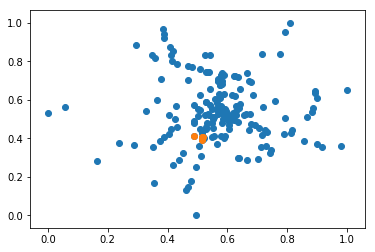

In [120]:
plot_all_cameras_loc(camdf,[1] + find_closest_cameras(1,camdf,3)[0].tolist())

In [82]:
from sklearn.neighbors import NearestNeighbors

In [92]:
def find_closest_cameras(cam_id,camdf,k):
    temp = camdf[["CAMERA_ID","GEO_LAT","GEO_LON"]]
    temp.set_index("CAMERA_ID",inplace=True)
    
    nb = NearestNeighbors(n_neighbors=k,n_jobs=-1).fit(temp)
    dists, idxs = nb.kneighbors([temp.loc[cam_id,:]])
    return idxs

In [102]:
find_closest_cameras(1,camdf,3)[0]

array([131, 132,  80], dtype=int64)

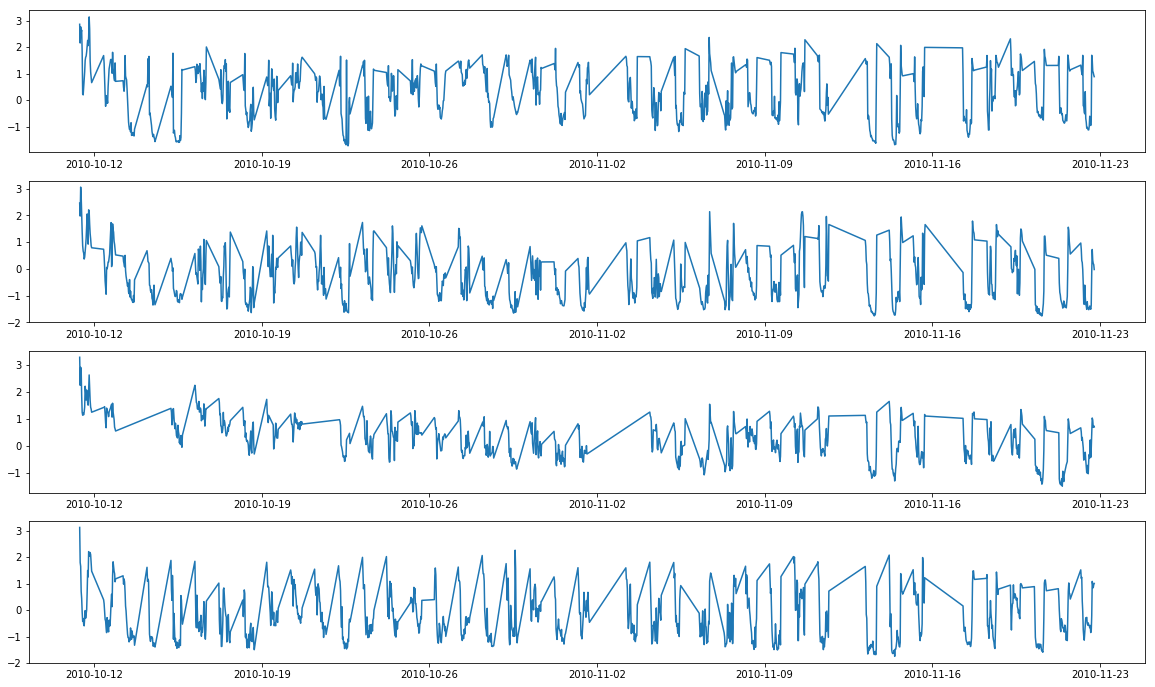

In [103]:
plot_timeseries(tdf_30min,[1] + find_closest_cameras(1,camdf,3)[0].tolist())

In [124]:
def crosscorr(data, id1, id2, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    datax = data.groupby("CAMERA_ID").get_group(id1)
    datax = datax.reset_index(level=0)
    datax = datax["SCALED_DENSITY_VALUE"]
    
    datay = data.groupby("CAMERA_ID").get_group(id2)
    datay = datay.reset_index(level=0)
    datay = datay["SCALED_DENSITY_VALUE"]
    return datax.corr(datay.shift(lag))

In [129]:
xcov_1_131 = [crosscorr(tdf_30min,1,131,lag=i) for i in range(500)]
xcov_1_132 = [crosscorr(tdf_30min,1,132,lag=i) for i in range(500)]
xcov_1_82 = [crosscorr(tdf_30min,1,82,lag=i) for i in range(500)]

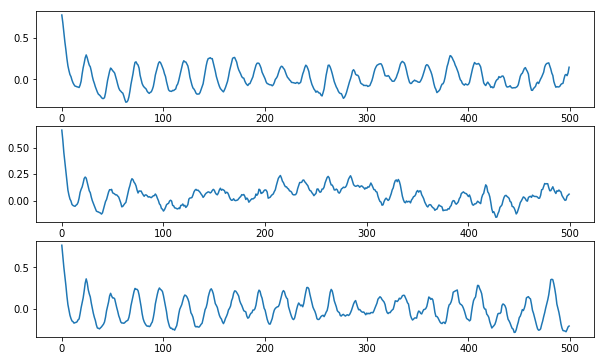

In [133]:
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(xcov_1_131)
plt.subplot(312)
plt.plot(xcov_1_132)
plt.subplot(313)
plt.plot(xcov_1_82)
plt.show()

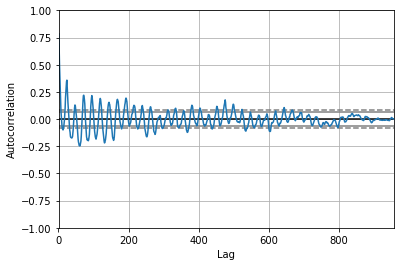

In [134]:
datax = tdf_30min.groupby("CAMERA_ID").get_group(1)
datax = datax.reset_index(level=0)
datax = datax["SCALED_DENSITY_VALUE"]
autocorrelation_plot(datax)

In [137]:
def plot_acfs(data, ids):
    
    plt.figure(figsize=(16,12))
    for i,_id in enumerate(ids):
        group = data.groupby("CAMERA_ID").get_group(_id)
        group = group.reset_index(level=0)
        ts = group.SCALED_DENSITY_VALUE
        ax = plt.subplot(len(ids),1,i+1)
        autocorrelation_plot(ts,ax)
    
    
    plt.show()    

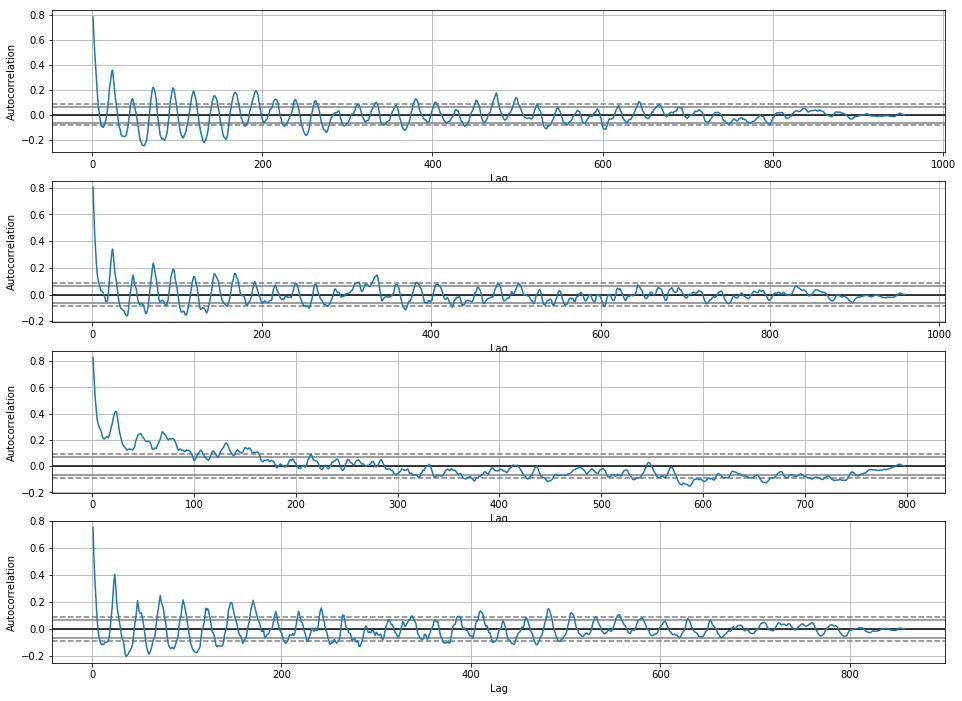

In [138]:
plot_acfs(tdf_30min,[1,131,132,82])